# YOLO NAS Training - UAV

## Necessary Setup and Imports

In [1]:
# One time installation.
!pip install super-gradients

## RESTART RUNTIME AFTER INSTALLATION IF RUNNING ON COLAB.

In [1]:
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, 
    coco_detection_yolo_format_val
)
from super_gradients.training import models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import (
    DetectionMetrics_050,
    DetectionMetrics_050_095
)
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from tqdm.auto import tqdm

import os
import requests
import zipfile
import cv2
import matplotlib.pyplot as plt
import glob
import numpy as np
import random

ImportError: No module named super_gradients.training

## Download Dataset

In [2]:
# Download dataset.
# def download_file(url, save_name):
#     if not os.path.exists(save_name):
#         print(f"Downloading file")
#         file = requests.get(url, stream=True)
#         total_size = int(file.headers.get('content-length', 0))
#         block_size = 1024
#         progress_bar = tqdm(
#             total=total_size, 
#             unit='iB', 
#             unit_scale=True
#         )
#         with open(os.path.join(save_name), 'wb') as f:
#             for data in file.iter_content(block_size):
#                 progress_bar.update(len(data))
#                 f.write(data)
#         progress_bar.close()
#     else:
#         print('File already present')
        
# download_file(
#     'https://www.dropbox.com/s/xc2890eh8ujy3cu/hituav-a-highaltitude-infrared-thermal-dataset.zip?dl=1',
#     'hituav-a-highaltitude-infrared-thermal-dataset.zip'
# )

In [3]:
# # Unzip the data file
# def unzip(zip_file=None):
#     try:
#         with zipfile.ZipFile(zip_file) as z:
#             z.extractall("./")
#             print("Extracted all")
#     except:
#         print("Invalid file")

# unzip('hituav-a-highaltitude-infrared-thermal-dataset.zip')

## Dataset Set Up

In [4]:
ROOT_DIR = '/home2/aryamaan_roy/Motorcycle-Violations-Complete/data/HNH'
train_imgs_dir = 'train/images'
train_labels_dir = 'train/labels'
val_imgs_dir = 'test/images'
val_labels_dir = 'test/labels'
test_imgs_dir = 'test/images'
test_labels_dir = 'test/labels'
classes = ['helmet', 'no-helmet']

In [5]:
dataset_params = {
    'data_dir':ROOT_DIR,
    'train_images_dir':train_imgs_dir,
    'train_labels_dir':train_labels_dir,
    'val_images_dir':val_imgs_dir,
    'val_labels_dir':val_labels_dir,
    'test_images_dir':test_imgs_dir,
    'test_labels_dir':test_labels_dir,
    'classes':classes 
}

In [6]:
# Global parameters.
EPOCHS = 100
BATCH_SIZE = 8
WORKERS = 4

## Visualize Ground Truth Images

In [7]:
colors = np.random.uniform(0, 255, size=(len(classes), 3))

In [8]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [9]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    height, width, _ = image.shape
    lw = max(round(sum(image.shape) / 2 * 0.003), 2)  # Line width.
    tf = max(lw - 1, 1) # Font thickness.
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*width)
        ymin = int(y1*height)
        xmax = int(x2*width)
        ymax = int(y2*height)

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        
        class_name = classes[int(labels[box_num])]

        color=colors[classes.index(class_name)]
        
        cv2.rectangle(
            image, 
            p1, p2,
            color=color, 
            thickness=lw,
            lineType=cv2.LINE_AA
        ) 

        # For filled rectangle.
        w, h = cv2.getTextSize(
            class_name, 
            0, 
            fontScale=lw / 3, 
            thickness=tf
        )[0]

        outside = p1[1] - h >= 3
        p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3

        cv2.rectangle(
            image, 
            p1, p2, 
            color=color, 
            thickness=-1, 
            lineType=cv2.LINE_AA
        )  
        cv2.putText(
            image, 
            class_name, 
            (p1[0], p1[1] - 5 if outside else p1[1] + h + 2),
            cv2.FONT_HERSHEY_SIMPLEX, 
            fontScale=lw/3.5, 
            color=(255, 255, 255), 
            thickness=tf, 
            lineType=cv2.LINE_AA
        )
    return image

In [10]:
# Function to plot images with the bounding boxes.
def plot(image_path, label_path, num_samples):
    all_training_images = glob.glob(image_path+'/*')
    all_training_labels = glob.glob(label_path+'/*')
    all_training_images.sort()
    all_training_labels.sort()
    
    temp = list(zip(all_training_images, all_training_labels))
    random.shuffle(temp)
    all_training_images, all_training_labels = zip(*temp)
    all_training_images, all_training_labels = list(all_training_images), list(all_training_labels)
    
    num_images = len(all_training_images)
    
    if num_samples == -1:
        num_samples = num_images
        
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        image_name = all_training_images[i].split(os.path.sep)[-1]
        image = cv2.imread(all_training_images[i])
        with open(all_training_labels[i], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label, x_c, y_c, w, h = label_line.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1) # Visualize 2x2 grid of images.
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

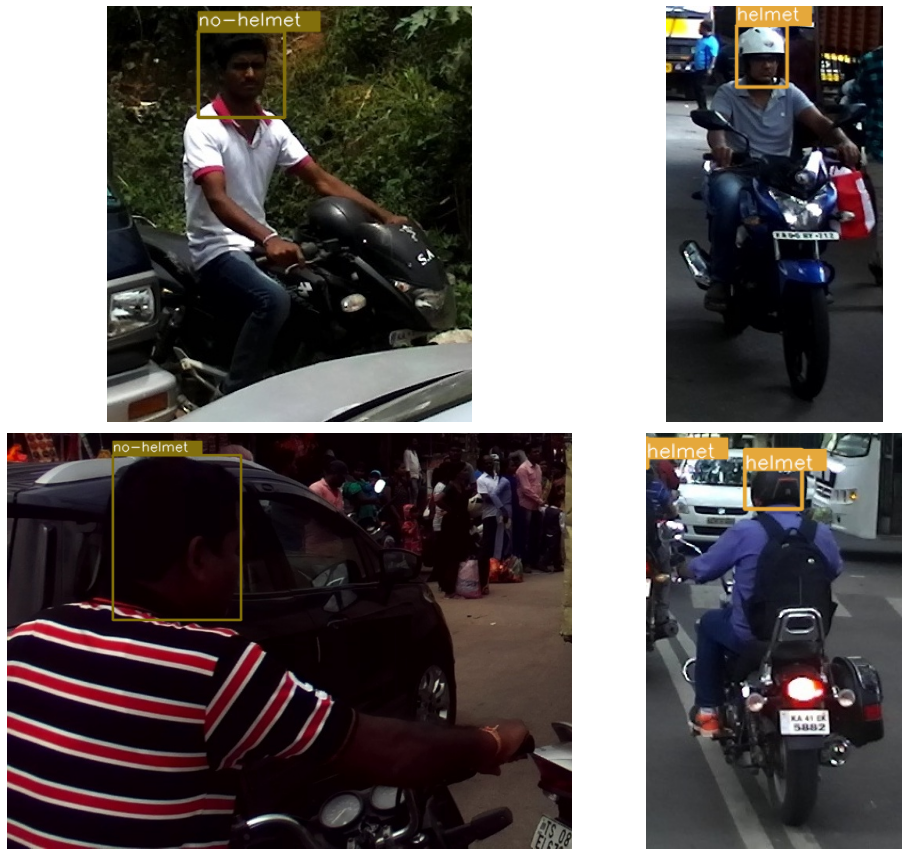

In [11]:
# Visualize a few training images.
plot(
    image_path=os.path.join(ROOT_DIR, train_imgs_dir), 
    label_path=os.path.join(ROOT_DIR, train_labels_dir),
    num_samples=4,
)

## Data Preparation

In [12]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':WORKERS
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':WORKERS
    }
)

Caching annotations:  87%|████████▋ | 401/462 [00:00<00:00, 428.75it/s]

## Transforms and Augmentations

In [13]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5),
 DetectionPaddedRescale('additional_samples_count': 0, 'non_em

In [14]:
train_data.dataset.transforms[0]

DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114)

In [15]:
############ An example on how to modify augmentations ###########
train_data.dataset.transforms.pop(2)

DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114)

In [16]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5),
 DetectionPaddedRescale('additional_samples_count': 0, 'non_empty_targets': False, 'swap': (2, 0, 1), 'input_dim': (640, 640), 'pad_value': 114),
 DetectionTargetsFormatTransform('additional_samples_count': 0, 'non_empty_targets': False, 'input_format': OrderedDi

Caching annotations: 100%|██████████| 462/462 [00:01<00:00, 432.63it/s]


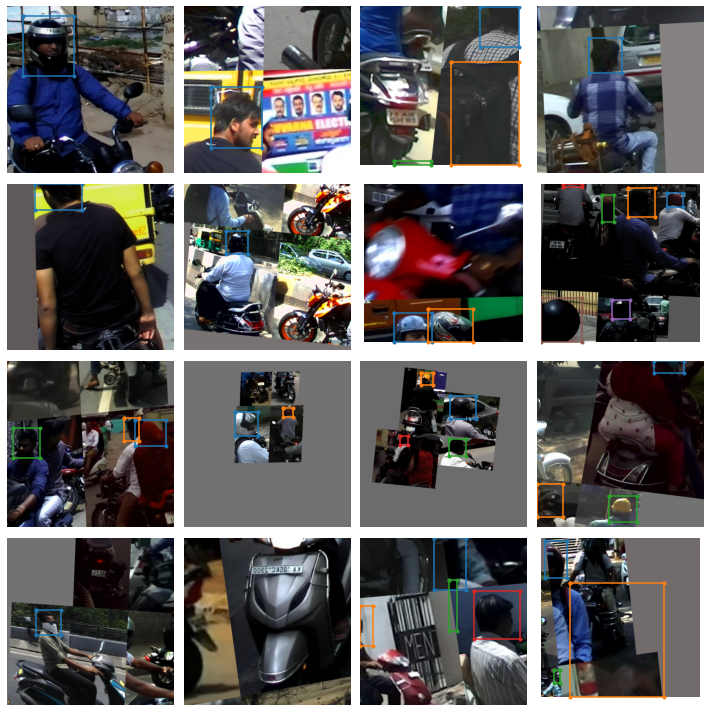

In [17]:
# We visualize the images without augmentation here.
train_data.dataset.plot(plot_transformed_data=True)

## Prepare Model and Training Parameters

In [18]:
train_params = {
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": EPOCHS,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        ),
        DetectionMetrics_050_095(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50:0.95'
}

In [19]:
models_to_train = [
    'yolo_nas_l'
]

In [20]:
CHECKPOINT_DIR = 'checkpoints'

In [21]:
import torch

torch.cuda.empty_cache()

### Model Training

In [22]:
for model_to_train in models_to_train:
    trainer = Trainer(
        experiment_name=model_to_train+'_'+str(EPOCHS)+'e', 
        ckpt_root_dir=CHECKPOINT_DIR
    )

    model = models.get(
        model_to_train, 
        num_classes=len(dataset_params['classes']), 
        pretrained_weights="coco"
    )

    trainer.train(
        model=model, 
        training_params=train_params, 
        train_loader=train_data, 
        valid_loader=val_data
    )

[2023-08-07 08:14:12] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.


The console stream is now moved to checkpoints/yolo_nas_l_100e/console_Aug07_08_14_17.txt


[2023-08-07 08:14:22] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
[2023-08-07 08:14:24] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 1547       (len(train_set))
    - Batch size per GPU:           8          (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             8          (num_gpus * batch_size)
    - Effective Batch size:         8          (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         193        (len(train_loader))
    - Gradient updates per epoch:   193        (len(train_loader) / batch_accumulate)

[2023-08-07 08:14:24] INFO - sg_trainer.py - Started training for 100 epochs (0/99)

Validating: 100%|██████████| 58/58 [00:12<00:00,  4.71it/s]
[2023-08-07 08:16:06] INFO - base_sg_logger.py

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 2.4848
│   ├── Ppyoloeloss/loss_iou = 0.2554
│   ├── Ppyoloeloss/loss_dfl = 1.4499
│   └── Ppyoloeloss/loss = 3.8482
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.5116
    ├── Ppyoloeloss/loss_iou = 0.2152
    ├── Ppyoloeloss/loss_dfl = 1.371
    ├── Ppyoloeloss/loss = 3.7351
    ├── Precision@0.50 = 0.0
    ├── Recall@0.50 = 0.0
    ├── Map@0.50 = 0.0288
    ├── F1@0.50 = 0.0
    ├── Precision@0.50:0.95 = 0.0
    ├── Recall@0.50:0.95 = 0.0
    ├── Map@0.50:0.95 = 0.0129
    └── F1@0.50:0.95 = 0.0



Train epoch 1:  89%|████████▉ | 172/193 [01:03<00:07,  2.80it/s, PPYoloELoss/loss=2.34, PPYoloELoss/loss_cls=1.16, PPYoloELoss/loss_dfl=1.24, PPYoloELoss/loss_iou=0.222, gpu_mem=6.87]

Train epoch 1:  89%|████████▉ | 172/193 [01:03<00:07,  2.70it/s, PPYoloELoss/loss=2.34, PPYoloELoss/loss_cls=1.16, PPYoloELoss/loss_dfl=1.24, PPYoloELoss/loss_iou=0.222, gpu_mem=6.87]
[2023-08-07 08:17:22] INFO - sg_trainer.py - 
[MODEL TRAINING EXECUTION HAS BEEN INTERRUPTED]... Please wait until SOFT-TERMINATION process finishes and saves all of the Model Checkpoints and log files before terminating...
[2023-08-07 08:17:22] INFO - sg_trainer.py - For HARD Termination - Stop the process again
[2023-08-07 08:17:22] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process
